# EDA

## Data Loading

In [12]:
import os
import pandas as pd

# the folder containing class subfolders
DATA_DIR = "/kaggle/input/garbage-classification-v2/garbage-dataset"

# 2. Collect records
records = []
for label in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, label)
    for fname in os.listdir(class_dir):
        records.append({
            "Images": fname,       # just the filename
            "Labels": label        # the folder name as class
        })

#DataFrame
df = pd.DataFrame(records)

print(df)

                 Images   Labels
0        metal_1617.jpg    metal
1        metal_1809.jpg    metal
2        metal_2658.jpg    metal
3        metal_2127.jpg    metal
4        metal_2152.jpg    metal
...                 ...      ...
19757   plastic_562.jpg  plastic
19758  plastic_2015.jpg  plastic
19759  plastic_2266.jpg  plastic
19760   plastic_389.jpg  plastic
19761  plastic_1651.jpg  plastic

[19762 rows x 2 columns]


## Image Count in Each Class

Labels
clothes       5327
glass         3061
plastic       1984
shoes         1977
cardboard     1825
paper         1680
metal         1020
biological     997
trash          947
battery        944
Name: count, dtype: int64
Total Number of Images :  19762


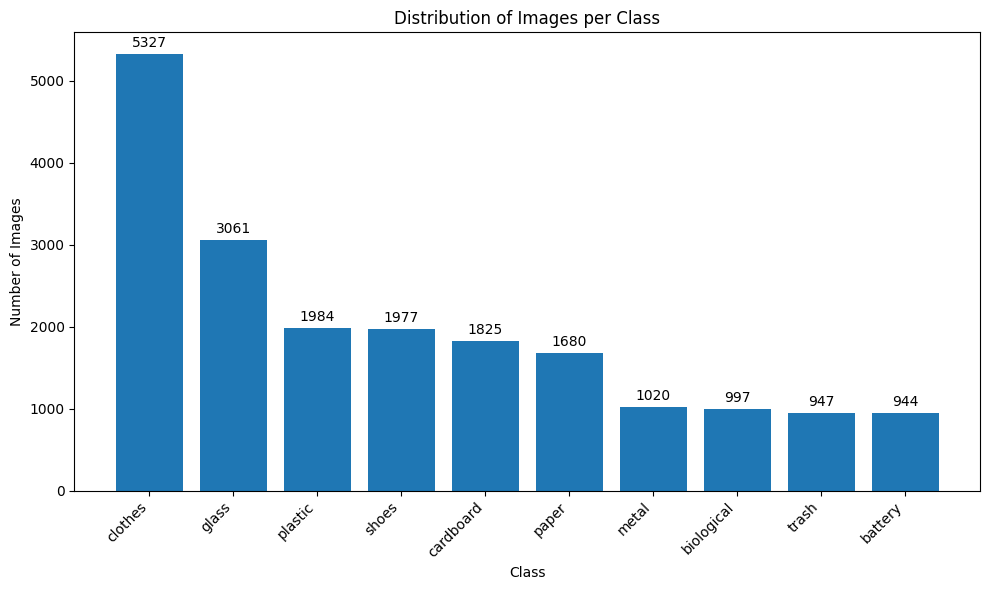

In [13]:
import matplotlib.pyplot as plt
print(df.Labels.value_counts())  # class balance


# Compute counts per class
counts = df['Labels'].value_counts()
print('Total Number of Images : ',len(df))
# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values)

# Annotate each bar with its height
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position
        height + 50,                         # y position (a bit above the bar)
        f'{int(height)}',                   # label
        ha='center', va='bottom'
    )

plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.tight_layout()
plt.show()

## Sample Images from each class

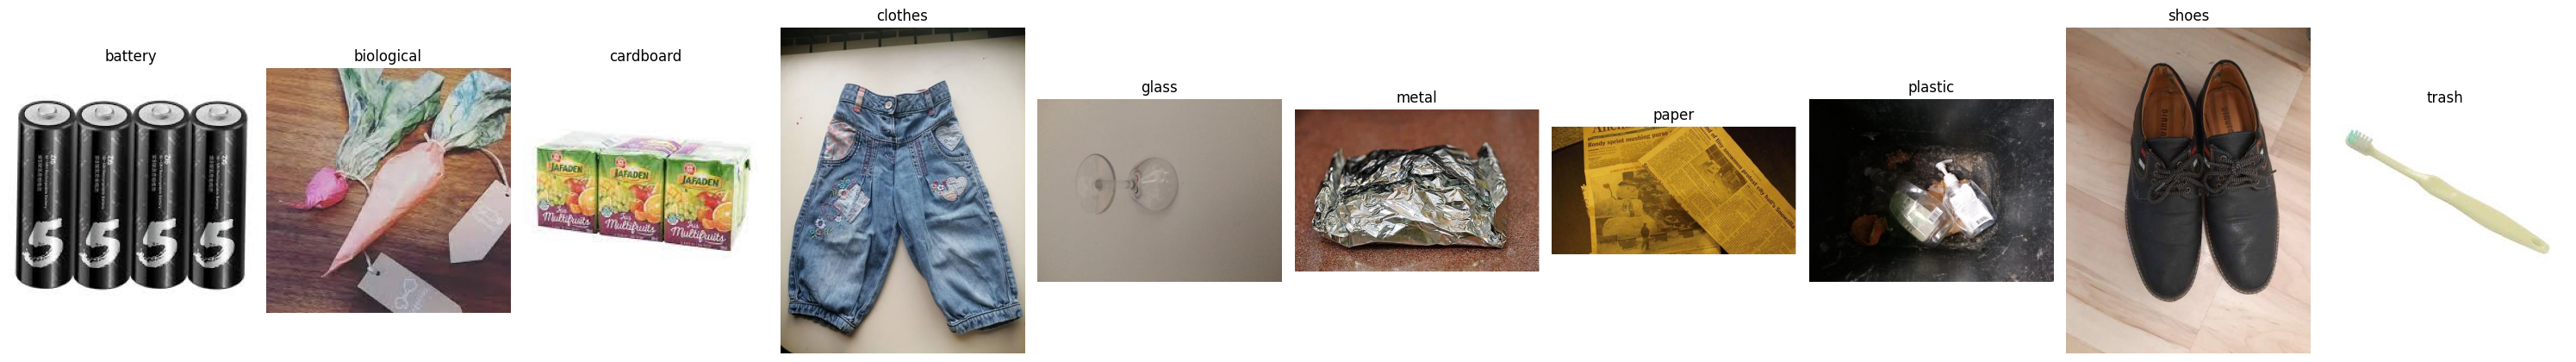

In [3]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

image_dir = "/kaggle/input/garbage-classification-v2/garbage-dataset"

#Group filenames by class
grouped_images = df.groupby('Labels')['Images'].apply(list)

#Sample one image path per class
random_images = []
for label, files in grouped_images.items():
    fname = random.choice(files)
    full_path = os.path.join(image_dir, label, fname)
    random_images.append((label, full_path))

#Plot
fig, axes = plt.subplots(1, len(random_images), figsize=(30, 5))
for ax, (label, path) in zip(axes, random_images):
    img = Image.open(path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


## Max height/width

In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = "/kaggle/input/garbage-classification-v2/garbage-dataset"

# Gather all widths & heights using existing df
widths, heights = [], []
for label, fname in zip(df['Labels'], df['Images']):
    path = os.path.join(DATA_DIR, label, fname)
    w, h = Image.open(path).size
    widths.append(w)
    heights.append(h)

# 3) Print the maximums
print(f"Max width:  {max(widths)} px")
print(f"Max height: {max(heights)} px")


Max width:  7786 px
Max height: 6283 px


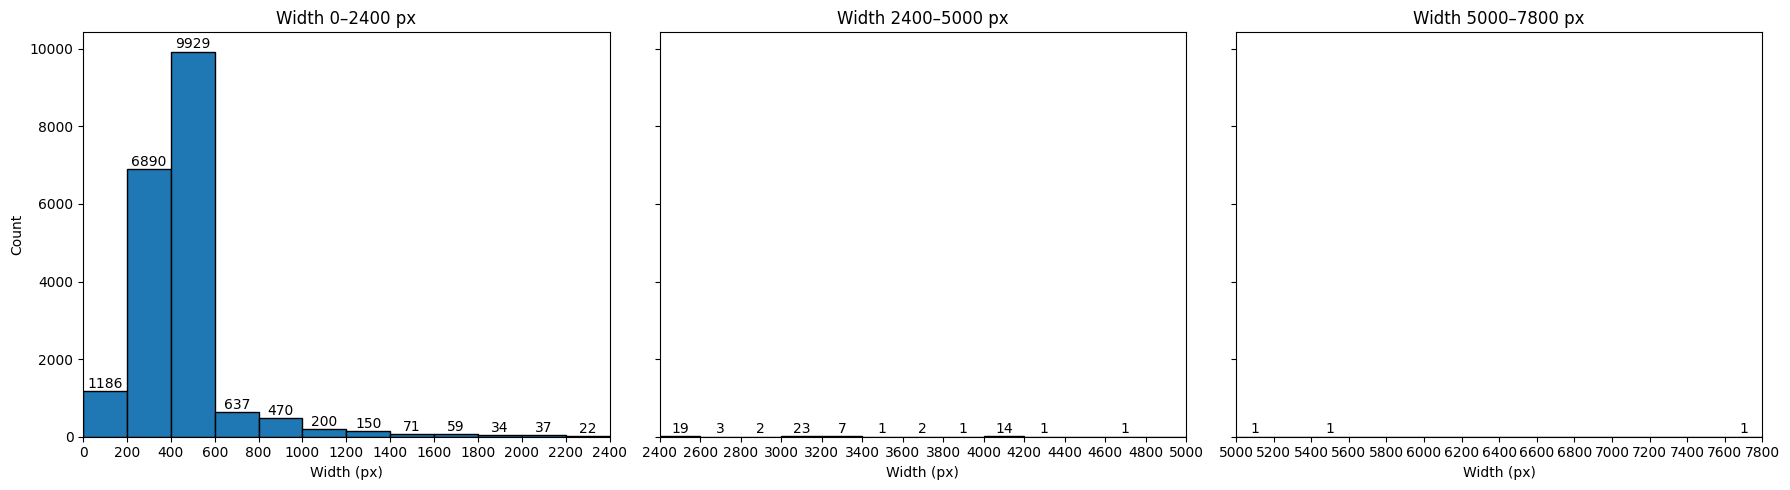

In [15]:
#Define three major ranges and sub-bins of 200px
ranges = [
    (0,   2400),
    (2400, 5000),
    (5000, 7800)
]
bin_width = 200

# Plot three histograms side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (start, end) in zip(axes, ranges):
    # build bins: start, start+200, ..., up to end
    bins = list(range(start, end, bin_width)) + [end]
    # filter widths to this segment
    segment = [w for w in widths if start <= w < end]
    counts, edges, patches = ax.hist(segment, bins=bins, edgecolor='black')
    
    # annotate each bar
    mids = [(edges[i] + edges[i+1]) / 2 for i in range(len(edges)-1)]
    for c, x in zip(counts, mids):
        if c>0:
            ax.text(x, c + 5, str(int(c)), ha='center', va='bottom')
    
    ax.set_title(f'Width {start}–{end} px')
    ax.set_xlabel('Width (px)')
    ax.set_xticks(bins)
    ax.set_xlim(start, end)

axes[0].set_ylabel('Count')
plt.tight_layout()
plt.show()


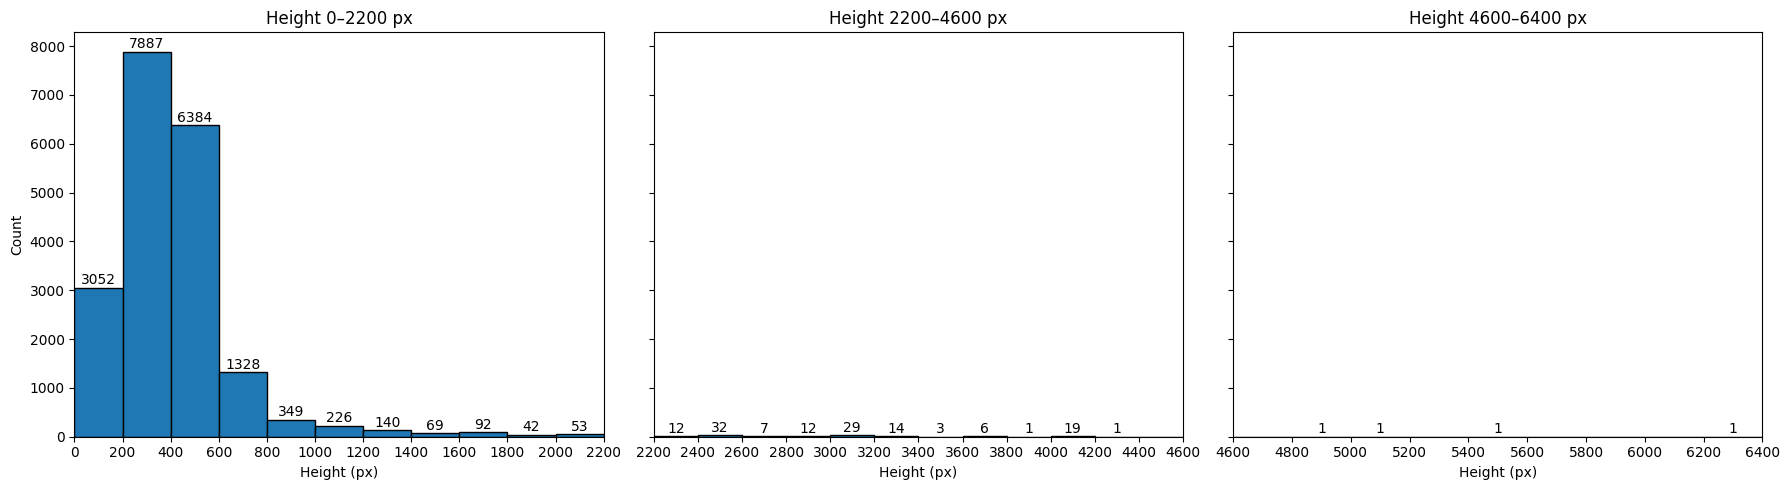

In [16]:
#Define three major height ranges and sub-bins of 200px
ranges = [
    (0,    2200),
    (2200, 4600),
    (4600, 6400)
]
bin_width = 200

# Plot three histograms side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (start, end) in zip(axes, ranges):
    # build bins: start, start+200, ..., up to end
    bins = list(range(start, end, bin_width)) + [end]
    # filter heights to this segment
    segment = [h for h in heights if start <= h < end]
    counts, edges, _ = ax.hist(segment, bins=bins, edgecolor='black')
    
    # annotate each bar with its count
    mids = [(edges[i] + edges[i+1]) / 2 for i in range(len(edges)-1)]
    for c, x in zip(counts, mids):
        if c>0:
            ax.text(x, c + 5, str(int(c)), ha='center', va='bottom')
    
    ax.set_title(f'Height {start}–{end} px')
    ax.set_xlabel('Height (px)')
    ax.set_xticks(bins)
    ax.set_xlim(start, end)

axes[0].set_ylabel('Count')
plt.tight_layout()
plt.show()

## Duplication Check

In [17]:
import os
import hashlib

DATA_DIR = "/kaggle/input/garbage-classification-v2/garbage-dataset"

#Hashing function
def calculate_hash(image_path, block_size=65536):
    h = hashlib.sha256()
    with open(image_path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()

# Track originals vs duplicates
hashes = {}      # hash -> (label, filename)
duplicates = []  # list of (dup_label, dup_fname, orig_label, orig_fname)

#Iterate through df rows
for label, fname in zip(df['Labels'], df['Images']):
    full_path = os.path.join(DATA_DIR, label, fname)
    img_hash  = calculate_hash(full_path)
    
    if img_hash in hashes:
        orig_label, orig_fname = hashes[img_hash]
        duplicates.append((label, fname, orig_label, orig_fname))
    else:
        hashes[img_hash] = (label, fname)

print(f"Total duplicates found: {len(duplicates)}\n")



Total duplicates found: 0



## Corrupted Image Check

In [18]:
bad = []
for lbl, fname in zip(df['Labels'], df['Images']):
    path = os.path.join(DATA_DIR, lbl, fname)
    try:
        # verify() doesn’t load the full image into memory
        Image.open(path).verify()
    except Exception:
        bad.append((lbl, fname))
print(f"Found {len(bad)} corrupted images:", bad[:10])

Found 0 corrupted images: []


## Aspect Ratio of Images

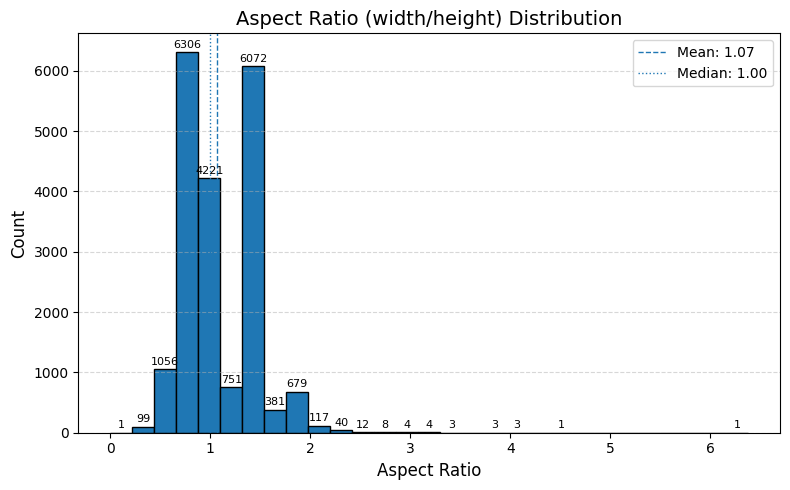

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

#Recompute ratios
ratios = []
for lbl, fname in zip(df['Labels'], df['Images']):
    w, h = Image.open(os.path.join(DATA_DIR, lbl, fname)).size
    ratios.append(w / h)
ratios = np.array(ratios)

#Compute mean and median
mean_ratio   = ratios.mean()
median_ratio = np.median(ratios)

#Build 30 equal bins between 0 and max
bins = np.linspace(0, ratios.max(), 30)


plt.figure(figsize=(8, 5))
counts, edges, patches = plt.hist(
    ratios,
    bins=bins,
    edgecolor='black'
)
# bars
bin_width = edges[1] - edges[0]
for c, left in zip(counts, edges[:-1]):
    if c > 0:
        plt.text(
            left + bin_width/2,  # center of bin
            c + ratios.size*0.002,  # small offset
            str(int(c)),
            ha='center',
            va='bottom',
            fontsize=8
        )
plt.axvline(mean_ratio,   linestyle='--', linewidth=1, label=f"Mean: {mean_ratio:.2f}")
plt.axvline(median_ratio, linestyle=':',  linewidth=1, label=f"Median: {median_ratio:.2f}")
plt.title("Aspect Ratio (width/height) Distribution", fontsize=14)
plt.xlabel("Aspect Ratio", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


 ## Display images with abnormal aspect ratio

Outliers per class:
Label
glass         91
cardboard     58
plastic       43
clothes       34
battery       30
paper         22
shoes         21
biological    19
trash         18
metal          9
Name: count, dtype: int64


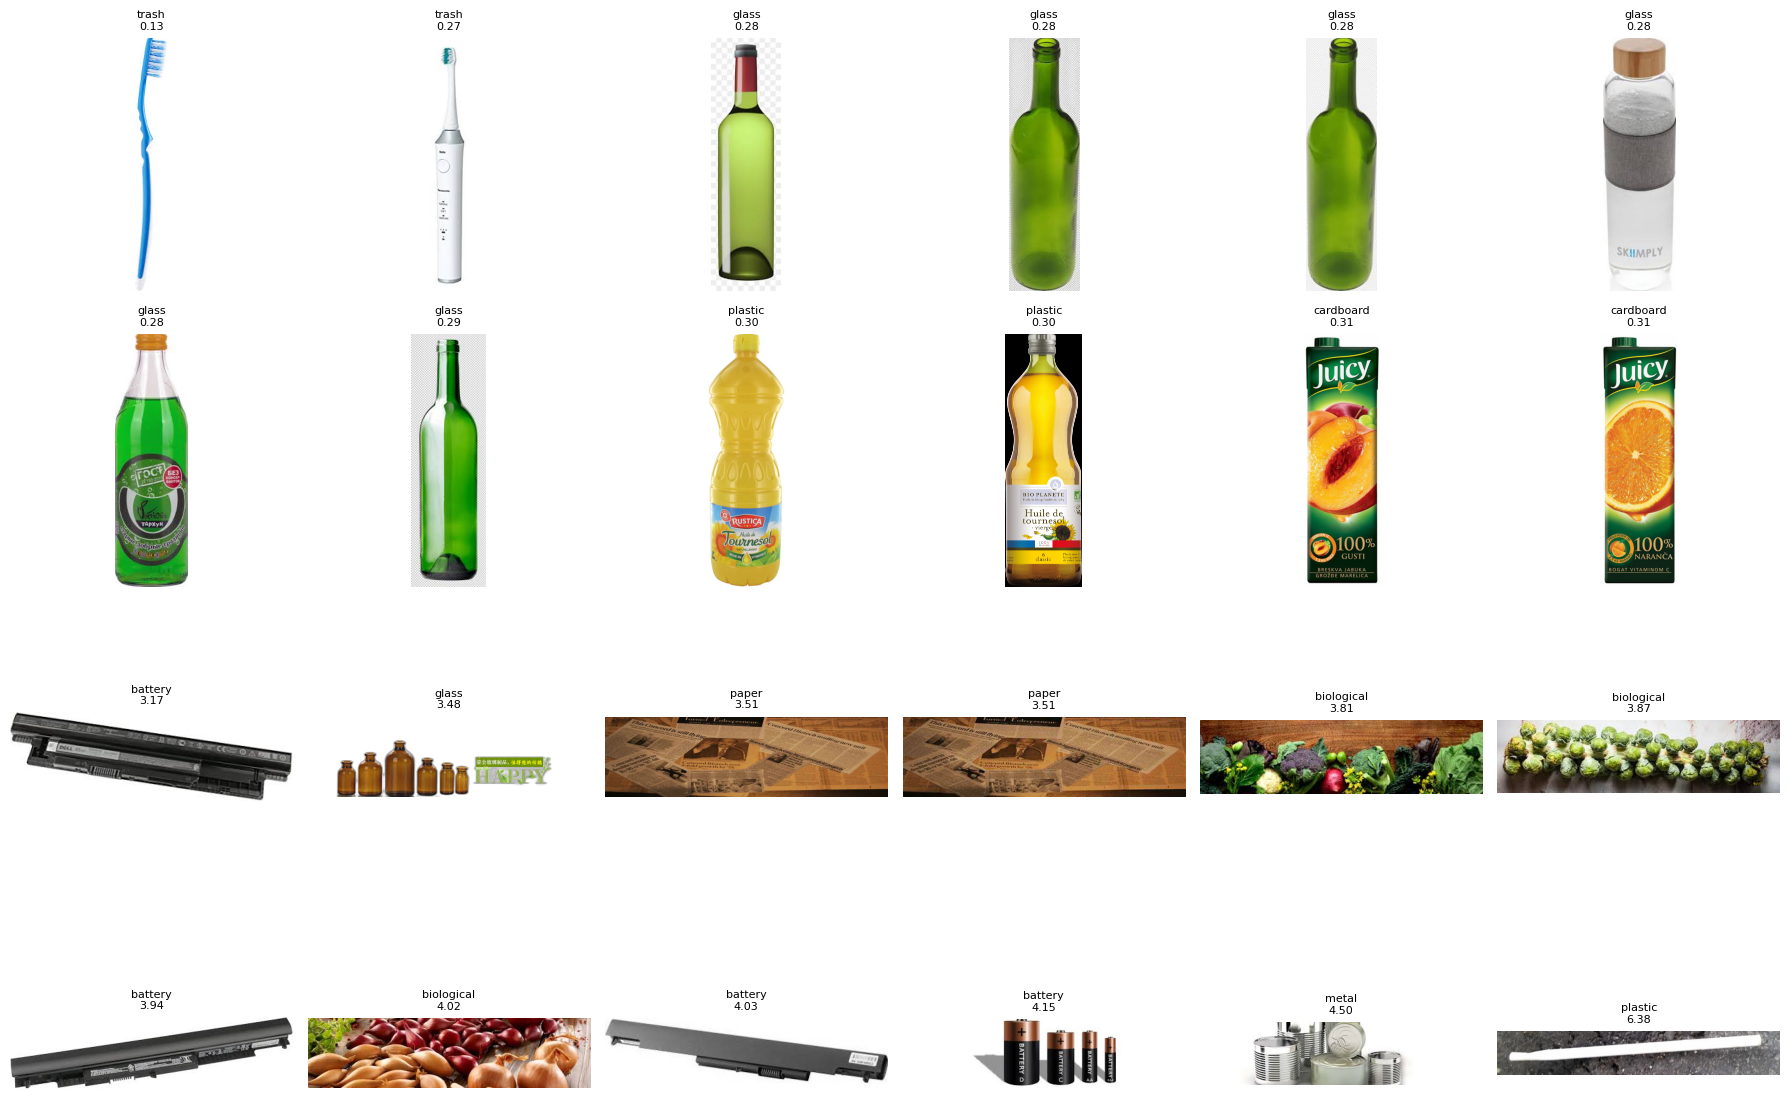

In [20]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# outliers DataFrame (ratio <0.5 or >2.0)
outliers = []
for lbl, fname in zip(df['Labels'], df['Images']):
    path = os.path.join(DATA_DIR, lbl, fname)
    w, h = Image.open(path).size
    ratio = w / h
    if ratio < 0.5 or ratio > 2.0:
        outliers.append((lbl, fname, ratio))
out_df = pd.DataFrame(outliers, columns=['Label','Images','AspectRatio'])

# See which classes have the most outliers
print("Outliers per class:")
print(out_df['Label'].value_counts())

# 3) Pick the 12 most “portrait” (small ratio) and 12 most “panorama” (large ratio)
sorted_df = out_df.sort_values('AspectRatio')
bottom12 = sorted_df.head(12)
top12    = sorted_df.tail(12)
review  = pd.concat([bottom12, top12]).reset_index(drop=True)

# 4) Display these 24 images in a 4×6 grid
cols = 6
rows = math.ceil(len(review)/cols)
plt.figure(figsize=(cols*3, rows*3))

for i, (_, row) in enumerate(review.iterrows()):
    lbl, fname, ratio = row['Label'], row['Images'], row['AspectRatio']
    ax = plt.subplot(rows, cols, i+1)
    img = Image.open(os.path.join(DATA_DIR, lbl, fname))
    ax.imshow(img)
    ax.set_title(f"{lbl}\n{ratio:.2f}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


# Data Preprocessing

## Map into 4 Classes

In [2]:
import os
import shutil

# Original and new paths
DATA_DIR     = "/kaggle/input/garbage-classification-v2/garbage-dataset"
NEW_DATA_DIR = "./garbage-classification-merged"   

# (Re)create the merged folder from scratch
if os.path.exists(NEW_DATA_DIR):
    shutil.rmtree(NEW_DATA_DIR)
os.makedirs(NEW_DATA_DIR)

#Define nmapping
merge_map = {
    'clothes':    'fabric',
    'shoes':      'fabric',
    'paper':      'paper',
    'cardboard':  'paper',
    'plastic':    'recyclable-inorganic',
    'metal':      'recyclable-inorganic',
    'glass':      'recyclable-inorganic',
    'biological': 'non-recyclable',
    'trash':      'non-recyclable',
    'battery':    'non-recyclable',
}

#Create each merged-category folder
for merged_cat in sorted(set(merge_map.values())):
    os.makedirs(os.path.join(NEW_DATA_DIR, merged_cat), exist_ok=True)

# Copy files from old→new
for old_cat, merged_cat in merge_map.items():
    src_folder = os.path.join(DATA_DIR, old_cat)
    dst_folder = os.path.join(NEW_DATA_DIR, merged_cat)

    if not os.path.isdir(src_folder):
        print(f"  Skipping nonexistent folder: {src_folder}")
        continue

    for fname in os.listdir(src_folder):
        src_path = os.path.join(src_folder, fname)
        dst_path = os.path.join(dst_folder, fname)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

    print(f"Copied {len(os.listdir(dst_folder))} files into '{merged_cat}'")

# Print final counts
print("\nFinal counts in 4 merged classes:")
for merged_cat in sorted(os.listdir(NEW_DATA_DIR)):
    count = len(os.listdir(os.path.join(NEW_DATA_DIR, merged_cat)))
    print(f"  {merged_cat}: {count}")


Copied 5327 files into 'fabric'
Copied 7304 files into 'fabric'
Copied 1680 files into 'paper'
Copied 3505 files into 'paper'
Copied 1984 files into 'recyclable-inorganic'
Copied 3004 files into 'recyclable-inorganic'
Copied 6065 files into 'recyclable-inorganic'
Copied 997 files into 'non-recyclable'
Copied 1944 files into 'non-recyclable'
Copied 2888 files into 'non-recyclable'

Final counts in 4 merged classes:
  fabric: 7304
  non-recyclable: 2888
  paper: 3505
  recyclable-inorganic: 6065


## Counts/Distribution of 4 classes

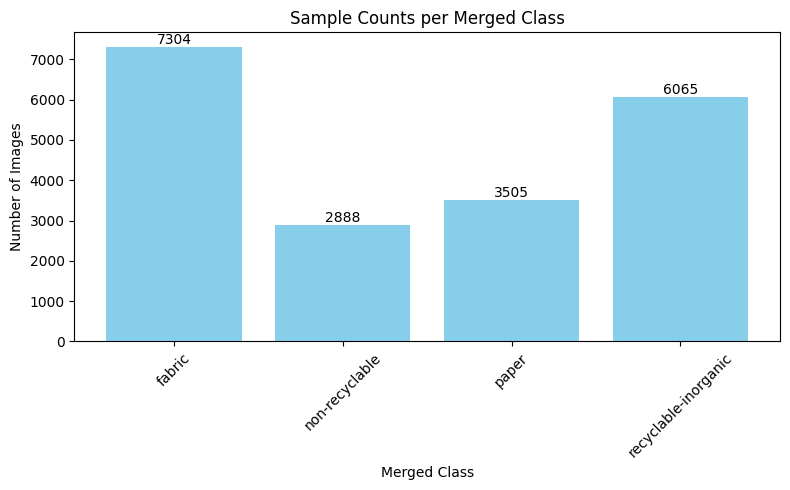

In [3]:
import os
import matplotlib.pyplot as plt

#Point to the merged dataset directory
merged_dir = "./garbage-classification-merged" 

#Gather counts
class_names = []
counts = []
for cls in sorted(os.listdir(merged_dir)):
    cls_path = os.path.join(merged_dir, cls)
    if os.path.isdir(cls_path):
        num_files = len([f for f in os.listdir(cls_path) 
                         if os.path.isfile(os.path.join(cls_path, f))])
        class_names.append(cls)
        counts.append(num_files)

# 3) Plot bar chart with annotations
plt.figure(figsize=(8,5))
bars = plt.bar(class_names, counts, color='skyblue')
plt.title("Sample Counts per Merged Class")
plt.xlabel("Merged Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position
        height + 10,                        # y position (slightly above bar)
        str(count),                         # text
        ha='center', va='bottom'
    )

plt.tight_layout()

## Sample images of 4 merged classes

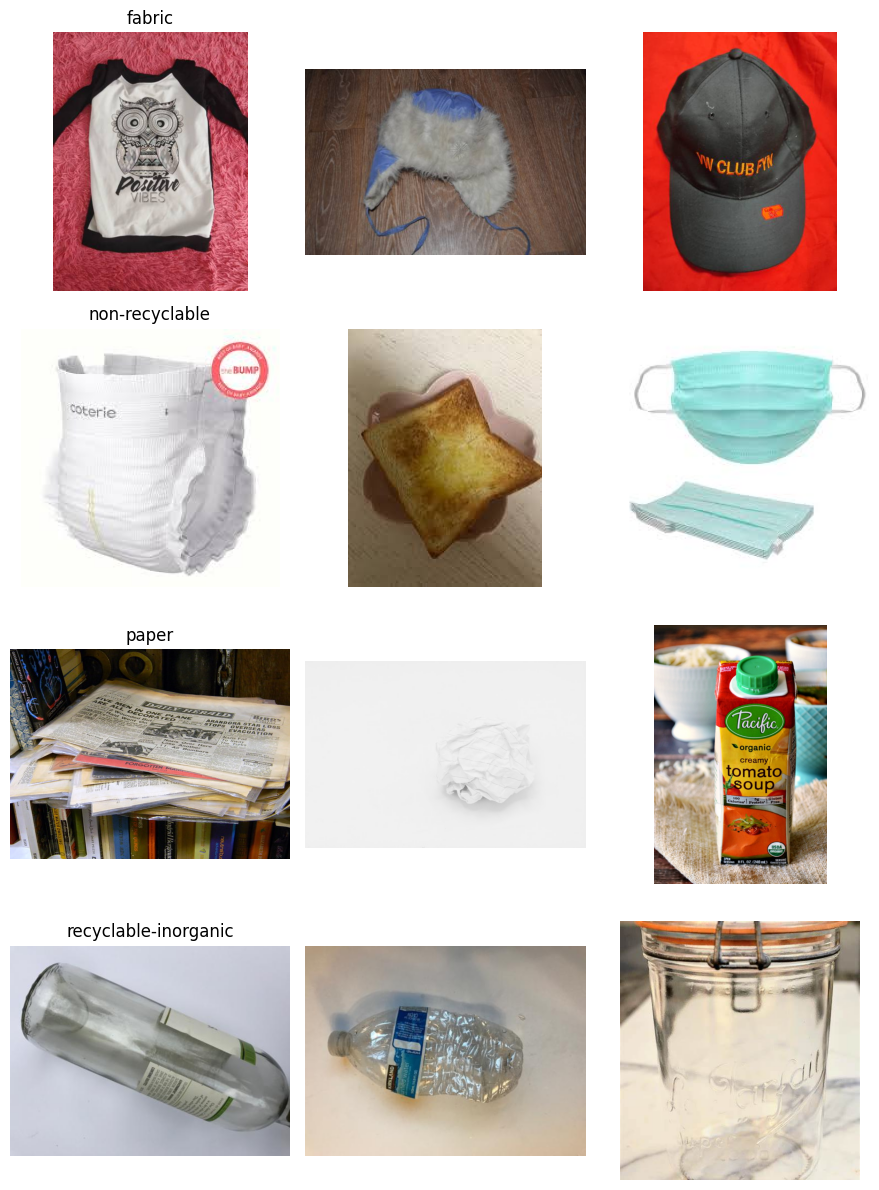

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

merged_dir = "/kaggle/working/garbage-classification-merged"

samples_per_class = 3

# one row per class, one column per sample
classes = sorted(os.listdir(merged_dir))
fig, axes = plt.subplots(
    nrows=len(classes),
    ncols=samples_per_class,
    figsize=(samples_per_class * 3, len(classes) * 3)
)

for i, cls in enumerate(classes):
    cls_path = os.path.join(merged_dir, cls)
    # list only image files
    imgs = [f for f in os.listdir(cls_path)
            if f.lower().endswith(('.jpg','.jpeg','.png'))]
    chosen = random.sample(imgs, min(samples_per_class, len(imgs)))
    for j, fname in enumerate(chosen):
        img = Image.open(os.path.join(cls_path, fname))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        # label the first column with the class name
        if j == 0:
            axes[i, j].set_title(cls, fontsize=12)

plt.tight_layout()
plt.show()


## Train-Test-Validaiton Split

In [4]:
import os
import shutil
import random
SRC_DIR = "./garbage-classification-merged"  # the merged 4-class folder
DST_DIR = "./garbage-split"                  # new split folder

# Define split ratios
train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15

# Make target subfolders
for split in ["train", "validation", "test"]:
    split_path = os.path.join(DST_DIR, split)
    os.makedirs(split_path, exist_ok=True)
    # inside each split, will create class subfolders later

#Iterate through each merged class
for cls in os.listdir(SRC_DIR):
    cls_src = os.path.join(SRC_DIR, cls)
    if not os.path.isdir(cls_src):
        continue

    # List and shuffle all files in this class
    files = [f for f in os.listdir(cls_src)
             if os.path.isfile(os.path.join(cls_src, f))]
    random.shuffle(files)

    # Compute split sizes
    n_total = len(files)
    n_train = int(n_total * train_ratio)
    n_val   = int(n_total * val_ratio)
    n_test  = n_total - n_train - n_val

    #Assign files
    splits = {
        "train":      files[:n_train],
        "validation": files[n_train:n_train + n_val],
        "test":       files[n_train + n_val:] 
    }

    #Copy into split folders
    for split, split_files in splits.items():
        dst_cls_dir = os.path.join(DST_DIR, split, cls)
        os.makedirs(dst_cls_dir, exist_ok=True)
        for fname in split_files:
            src_path = os.path.join(cls_src, fname)
            dst_path = os.path.join(dst_cls_dir, fname)
            shutil.copy(src_path, dst_path)

    print(f"{cls:20s}: "
          f"{n_train} train, {n_val} val, {n_test} test (total {n_total})")

#summary counts
print("\nFinal split counts:")
for split in ["train", "validation", "test"]:
    print(f" [{split}]")
    for cls in os.listdir(os.path.join(DST_DIR, split)):
        cnt = len(os.listdir(os.path.join(DST_DIR, split, cls)))
        print(f"   {cls:20s}: {cnt}")


recyclable-inorganic: 4245 train, 909 val, 911 test (total 6065)
paper               : 2453 train, 525 val, 527 test (total 3505)
fabric              : 5112 train, 1095 val, 1097 test (total 7304)
non-recyclable      : 2021 train, 433 val, 434 test (total 2888)

Final split counts:
 [train]
   recyclable-inorganic: 4245
   paper               : 2453
   fabric              : 5112
   non-recyclable      : 2021
 [validation]
   recyclable-inorganic: 909
   paper               : 525
   fabric              : 1095
   non-recyclable      : 433
 [test]
   recyclable-inorganic: 911
   paper               : 527
   fabric              : 1097
   non-recyclable      : 434


## Oversampling

In [6]:
import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Build initial DataFrame of training images and labels
train_dir = "./garbage-split/train"
data = []
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        for fname in os.listdir(cls_path):
            if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                data.append({"filename": os.path.join(train_dir, cls, fname),
                             "label": cls})

df_train = pd.DataFrame(data)

#inspect original class counts
orig_counts = df_train['label'].value_counts()
print("Original training class counts:\n", orig_counts)

#Perform oversampling to match the majority class
max_count = orig_counts.max()
dfs = []
for label, group in df_train.groupby('label'):
    if len(group) < max_count:
        # upsample minority class
        upsampled = resample(group,
                             replace=True,
                             n_samples=max_count,
                             random_state=42)
        dfs.append(upsampled)
    else:
        dfs.append(group)

df_over = pd.concat(dfs).reset_index(drop=True)

#new class distribution
over_counts = df_over['label'].value_counts()
print("\nOversampled training class counts:\n", over_counts)


Original training class counts:
 label
fabric                  5112
recyclable-inorganic    4245
paper                   2453
non-recyclable          2021
Name: count, dtype: int64

Oversampled training class counts:
 label
fabric                  5112
non-recyclable          5112
paper                   5112
recyclable-inorganic    5112
Name: count, dtype: int64


## Data Augmentation

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1) Define your train generator (same augmentations as before)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2) Build train_flow from the oversampled DataFrame
train_flow = train_gen.flow_from_dataframe(
    dataframe=df_over,
    x_col='filename',
    y_col='label',
    target_size=(160, 160),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# 3) Validation & test remain directory-based
val_gen = ImageDataGenerator(rescale=1./255)
val_flow = val_gen.flow_from_directory(
    "./garbage-split/validation",
    target_size=(160, 160),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

test_flow = val_gen.flow_from_directory(
    "./garbage-split/test",
    target_size=(160, 160),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)



Found 20448 validated image filenames belonging to 4 classes.
Found 2962 images belonging to 4 classes.
Found 2969 images belonging to 4 classes.


## Class-weighting

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = train_flow.classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced",classes=classes,y=y_train)
class_weight = dict(zip(classes, weights))
print("Class weights:", class_weight)


Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [8]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Building CNN

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 455,236 (1.74 MB)

 Trainable params: 455,236 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 152s 451ms/step - accuracy: 0.3280 - loss: 1.3317 - val_accuracy: 0.4527 - val_loss: 1.1837
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 147s 447ms/step - accuracy: 0.5133 - loss: 1.1253 - val_accuracy: 0.5780 - val_loss: 1.0238
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 148s 452ms/step - accuracy: 0.5571 - loss: 1.0558 - val_accuracy: 0.5425 - val_loss: 1.1183
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 149s 456ms/step - accuracy: 0.6045 - loss: 0.9583 - val_accuracy: 0.5868 - val_loss: 0.9328
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 147s 448ms/step - accuracy: 0.6450 - loss: 0.8751 - val_accuracy: 0.5837 - val_loss: 0.9803
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 147s 451ms/step - accuracy: 0.6697 - loss: 0.8154 - val_accuracy: 0.6766 - val_loss: 0.8007
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 147s 449ms/step - accuracy: 0.7152 - loss: 0.7372 - val_accuracy: 0.6962 - val_loss: 0.7523
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 147s 450ms/step - accuracy: 0.7343 -

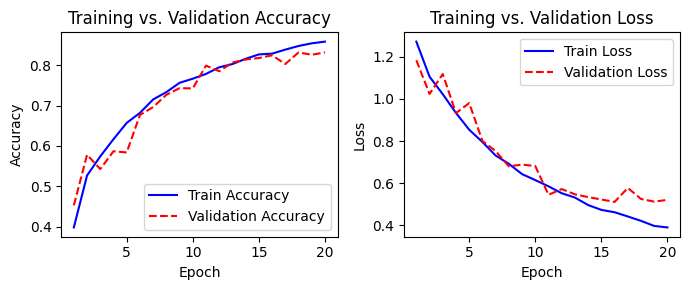

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step
                      precision    recall  f1-score   support

              fabric       0.91      0.85      0.88      1097
      non-recyclable       0.78      0.73      0.75       434
               paper       0.70      0.91      0.79       527
recyclable-inorganic       0.84      0.79      0.81       911

            accuracy                           0.82      2969
           macro avg       0.81      0.82      0.81      2969
        weighted avg       0.83      0.82      0.82      2969



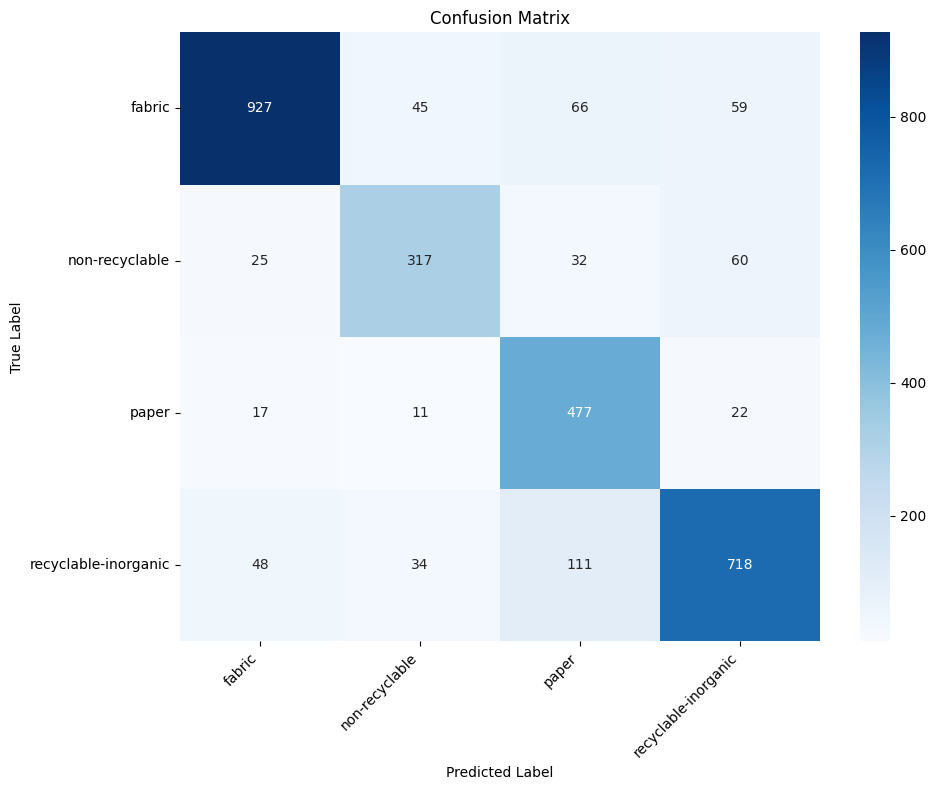

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
import tensorflow as tf
with tf.device('/GPU:0'):
    model = Sequential([
        # Block 1: 32 filters
        Conv2D(32, (3,3), padding='same', activation='relu',
               input_shape=(160,160,3)),
        MaxPooling2D(),
    
        # Block 2: 64 filters
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Block 3: 128 filters
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Block 4: 256 filters
        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Global pooling instead of flatten
        GlobalAveragePooling2D(),
    
        # Classifier head
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(train_flow,validation_data=val_flow,epochs=20,class_weight=class_weight)

import matplotlib.pyplot as plt

# 1) Extract metrics from history
train_acc   = history.history['accuracy']
val_acc     = history.history['val_accuracy']
train_loss  = history.history['loss']
val_loss    = history.history['val_loss']
epochs      = range(1, len(train_acc) + 1)

# 2) Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# — Accuracy subplot
axes[0].plot(epochs, train_acc, 'b-', label='Train Accuracy')
axes[0].plot(epochs, val_acc,   'r--', label='Validation Accuracy')
axes[0].set_title('Training vs. Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# — Loss subplot
axes[1].plot(epochs, train_loss, 'b-', label='Train Loss')
axes[1].plot(epochs, val_loss,   'r--', label='Validation Loss')
axes[1].set_title('Training vs. Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Get predictions on the test set
y_prob = model.predict(test_flow, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# 2) True labels
y_true = test_flow.classes

# 3) Build list of class names in index order
idx_to_label = {v:k for k,v in test_flow.class_indices.items()}
target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# 4) Print the classification report
print(classification_report(y_true,y_pred,target_names=target_names,digits=2))

# 5) Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=target_names,
    yticklabels=target_names,
    cmap='Blues'
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [37]:
import os
import random
import itertools
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ─── 1) Hyperparameter grid ─────────────────────────────────────────────────
param_grid = {
    'optimizer': [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD],
    'lr':        [1e-2, 1e-3, 1e-4],
    'batch':     [32, 64, 128],
    'dropout':   [0.4, 0.5, 0.6],
    'dense':     [128, 256, 512]
}

all_combos = list(itertools.product(*param_grid.values()))
trials = random.sample(all_combos, k=8)   # pick 8 random configs
results = []

#Data generators (reuse for each trial but batch size will change)
train_base = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_base = ImageDataGenerator(rescale=1./255)

# ───  Random-search loop ───────────────────────────────────────────────────
for opt_name, lr, batch_size, drop_rate,dense_units in trials:
    tf.keras.backend.clear_session()
    print(f"\n=== Trial: opt={opt_name}, lr={lr}, bs={batch_size}, dr={drop_rate}, dense={dense_units} ===")
    
    # prepare flows with this batch size
    train_flow = train_base.flow_from_dataframe(
        dataframe=df_over,
        x_col='filename',
        y_col='label',
        target_size=(160,160),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )
    val_flow = test_base.flow_from_directory(
        "./garbage-split/validation",
        target_size=(160,160),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )
    
    #model building
    with tf.device('/GPU:0'):
        model = Sequential([
            Conv2D(32,(3,3),padding='same',activation='relu',
                   input_shape=(160,160,3)),
            MaxPooling2D(),
            Conv2D(64,(3,3),padding='same',activation='relu'),
            MaxPooling2D(),
            Conv2D(128,(3,3),padding='same',activation='relu'),
            MaxPooling2D(),
            Conv2D(256,(3,3),padding='same',activation='relu'),
            MaxPooling2D(),
            GlobalAveragePooling2D(),
            Dense(dense_units,activation='relu'),
            Dropout(drop_rate),
            Dense(4,activation='softmax')
        ])
        # compile
        # instantiate optimizer with  lr
        if opt_name is tf.keras.optimizers.SGD:
            optimizer = opt_name(learning_rate=lr, momentum=0.9)
        else:
            # covers tf.keras.optimizers.Adam
            optimizer = opt_name(learning_rate=lr)
            
        model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    
    # callbacks
    cbs = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]
    
    history = model.fit(train_flow,validation_data=val_flow,epochs=10,class_weight=class_weight,   callbacks=cbs, verbose=1)
    
    # best val_acc
    best_val = max(history.history['val_accuracy'])
    results.append({
        'optimizer':  opt_name.__name__ if not isinstance(opt_name,str) else opt_name,
        'lr':         lr,
        'batch_size': batch_size,
        'dropout':    drop_rate,
        'dense':      dense_units,
        'best_val_acc': best_val
    })

# summary
df = pd.DataFrame(results).sort_values('best_val_acc', ascending=False)
print("\n=== Top Configurations ===")
print(df.head())



=== Trial: opt=<class 'keras.src.optimizers.adam.Adam'>, lr=0.001, bs=32, dr=0.4, dense=256 ===
Found 20448 validated image filenames belonging to 4 classes.
Found 2962 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747135601.430377     193 service.cc:148] XLA service 0x7a780c00d330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747135601.431430     193 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747135601.431450     193 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747135601.825978     193 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/639 ━━━━━━━━━━━━━━━━━━━━ 1:43:21 10s/step - accuracy: 0.2500 - loss: 1.3800

I0000 00:00:1747135606.640372     193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


639/639 ━━━━━━━━━━━━━━━━━━━━ 159s 234ms/step - accuracy: 0.3741 - loss: 1.3010 - val_accuracy: 0.5084 - val_loss: 1.1041 - learning_rate: 0.0010
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 148s 230ms/step - accuracy: 0.5222 - loss: 1.1136 - val_accuracy: 0.5253 - val_loss: 1.1120 - learning_rate: 0.0010
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 228ms/step - accuracy: 0.5882 - loss: 0.9950 - val_accuracy: 0.5510 - val_loss: 1.0472 - learning_rate: 0.0010
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.6167 - loss: 0.9304 - val_accuracy: 0.6411 - val_loss: 0.8848 - learning_rate: 0.0010
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.6576 - loss: 0.8541 - val_accuracy: 0.6826 - val_loss: 0.8197 - learning_rate: 0.0010
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 228ms/step - accuracy: 0.6789 - loss: 0.8035 - val_accuracy: 0.6506 - val_loss: 0.8916 - learning_rate: 0.0010
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 150s 231ms/step - accuracy: 0.7090 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 150s 225ms/step - accuracy: 0.2495 - loss: 1.4890 - val_accuracy: 0.1772 - val_loss: 1.3938 - learning_rate: 0.0100
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.2456 - loss: 1.3873 - val_accuracy: 0.3069 - val_loss: 1.3887 - learning_rate: 0.0100
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 227ms/step - accuracy: 0.2451 - loss: 1.3870 - val_accuracy: 0.3697 - val_loss: 1.3863 - learning_rate: 0.0100
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 227ms/step - accuracy: 0.2458 - loss: 1.3870 - val_accuracy: 0.3069 - val_loss: 1.3745 - learning_rate: 0.0100
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 226ms/step - accuracy: 0.2474 - loss: 1.3871 - val_accuracy: 0.1462 - val_loss: 1.4051 - learning_rate: 0.0100
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 148s 229ms/step - accuracy: 0.2549 - loss: 1.3867 - val_accuracy: 0.1462 - val_loss: 1.3944 - learning_rate: 0.0100
Epoch 7/10
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.2491 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 158s 454ms/step - accuracy: 0.2980 - loss: 1.3569 - val_accuracy: 0.4203 - val_loss: 1.2530 - learning_rate: 1.0000e-04
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 444ms/step - accuracy: 0.4463 - loss: 1.2207 - val_accuracy: 0.5263 - val_loss: 1.1283 - learning_rate: 1.0000e-04
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 443ms/step - accuracy: 0.4916 - loss: 1.1725 - val_accuracy: 0.5530 - val_loss: 1.0822 - learning_rate: 1.0000e-04
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 441ms/step - accuracy: 0.5167 - loss: 1.1413 - val_accuracy: 0.5432 - val_loss: 1.1029 - learning_rate: 1.0000e-04
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 444ms/step - accuracy: 0.5402 - loss: 1.0971 - val_accuracy: 0.5736 - val_loss: 1.0522 - learning_rate: 1.0000e-04
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 444ms/step - accuracy: 0.5360 - loss: 1.0997 - val_accuracy: 0.5300 - val_loss: 1.1264 - learning_rate: 1.0000e-04
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 443ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 152s 229ms/step - accuracy: 0.3281 - loss: 1.3340 - val_accuracy: 0.4747 - val_loss: 1.1865 - learning_rate: 1.0000e-04
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 227ms/step - accuracy: 0.4747 - loss: 1.1903 - val_accuracy: 0.5341 - val_loss: 1.0994 - learning_rate: 1.0000e-04
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 228ms/step - accuracy: 0.5138 - loss: 1.1299 - val_accuracy: 0.4814 - val_loss: 1.1969 - learning_rate: 1.0000e-04
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 225ms/step - accuracy: 0.5473 - loss: 1.0797 - val_accuracy: 0.5398 - val_loss: 1.0712 - learning_rate: 1.0000e-04
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 224ms/step - accuracy: 0.5501 - loss: 1.0654 - val_accuracy: 0.5321 - val_loss: 1.0938 - learning_rate: 1.0000e-04
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.5707 - loss: 1.0351 - val_accuracy: 0.5503 - val_loss: 1.0711 - learning_rate: 1.0000e-04
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 224ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 151s 227ms/step - accuracy: 0.3267 - loss: 1.3420 - val_accuracy: 0.4102 - val_loss: 1.2318 - learning_rate: 1.0000e-04
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 225ms/step - accuracy: 0.4719 - loss: 1.1974 - val_accuracy: 0.4524 - val_loss: 1.2061 - learning_rate: 1.0000e-04
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 224ms/step - accuracy: 0.5061 - loss: 1.1433 - val_accuracy: 0.5625 - val_loss: 1.0558 - learning_rate: 1.0000e-04
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 224ms/step - accuracy: 0.5363 - loss: 1.1101 - val_accuracy: 0.5493 - val_loss: 1.0771 - learning_rate: 1.0000e-04
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 225ms/step - accuracy: 0.5490 - loss: 1.0857 - val_accuracy: 0.5493 - val_loss: 1.0921 - learning_rate: 1.0000e-04
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 224ms/step - accuracy: 0.5626 - loss: 1.0481 - val_accuracy: 0.5780 - val_loss: 1.0049 - learning_rate: 1.0000e-04
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 225ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 151s 228ms/step - accuracy: 0.3592 - loss: 1.3124 - val_accuracy: 0.5452 - val_loss: 1.0917 - learning_rate: 0.0010
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.5188 - loss: 1.1235 - val_accuracy: 0.5996 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 227ms/step - accuracy: 0.5826 - loss: 0.9980 - val_accuracy: 0.6533 - val_loss: 0.8453 - learning_rate: 0.0010
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 227ms/step - accuracy: 0.6253 - loss: 0.9003 - val_accuracy: 0.5645 - val_loss: 1.1719 - learning_rate: 0.0010
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.6560 - loss: 0.8474 - val_accuracy: 0.6982 - val_loss: 0.7842 - learning_rate: 0.0010
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.6935 - loss: 0.7725 - val_accuracy: 0.7178 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.7211 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 178s 970ms/step - accuracy: 0.2612 - loss: 2.1188 - val_accuracy: 0.1870 - val_loss: 1.3737 - learning_rate: 0.0100
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 907ms/step - accuracy: 0.2609 - loss: 1.3832 - val_accuracy: 0.3035 - val_loss: 1.3760 - learning_rate: 0.0100
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 921ms/step - accuracy: 0.2699 - loss: 1.3799 - val_accuracy: 0.1867 - val_loss: 1.3806 - learning_rate: 0.0100
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 151s 905ms/step - accuracy: 0.2642 - loss: 1.3866 - val_accuracy: 0.1938 - val_loss: 1.3729 - learning_rate: 0.0100
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 912ms/step - accuracy: 0.2870 - loss: 1.3716 - val_accuracy: 0.4217 - val_loss: 1.3425 - learning_rate: 0.0100
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 918ms/step - accuracy: 0.3160 - loss: 1.3587 - val_accuracy: 0.4065 - val_loss: 1.3331 - learning_rate: 0.0100
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 911ms/step - accuracy: 0.3183 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 148s 226ms/step - accuracy: 0.2546 - loss: 1.3858 - val_accuracy: 0.3072 - val_loss: 1.3866 - learning_rate: 1.0000e-04
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 227ms/step - accuracy: 0.2583 - loss: 1.3841 - val_accuracy: 0.2782 - val_loss: 1.3864 - learning_rate: 1.0000e-04
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 225ms/step - accuracy: 0.2760 - loss: 1.3822 - val_accuracy: 0.2860 - val_loss: 1.3863 - learning_rate: 1.0000e-04
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 225ms/step - accuracy: 0.2656 - loss: 1.3808 - val_accuracy: 0.2387 - val_loss: 1.3846 - learning_rate: 1.0000e-04
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.2799 - loss: 1.3794 - val_accuracy: 0.2968 - val_loss: 1.3830 - learning_rate: 1.0000e-04
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.2896 - loss: 1.3774 - val_accuracy: 0.2694 - val_loss: 1.3816 - learning_rate: 1.0000e-04
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 224ms/

## Best Parameter After Tuning

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ttrain generator 
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Build train_flow from the oversampled DataFrame
train_flow = train_gen.flow_from_dataframe(
    dataframe=df_over,
    x_col='filename',
    y_col='label',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# 3) Validation & test remain directory-based
val_gen = ImageDataGenerator(rescale=1./255)
val_flow = val_gen.flow_from_directory(
    "./garbage-split/validation",
    target_size=(160, 160),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_flow = val_gen.flow_from_directory(
    "./garbage-split/test",
    target_size=(160, 160),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)



Found 20448 validated image filenames belonging to 4 classes.
Found 2962 images belonging to 4 classes.
Found 2969 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 522,052 (1.99 MB)

 Trainable params: 522,052 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 152s 229ms/step - accuracy: 0.3471 - loss: 1.3201 - val_accuracy: 0.4737 - val_loss: 1.1566
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 226ms/step - accuracy: 0.5075 - loss: 1.1388 - val_accuracy: 0.5885 - val_loss: 0.9817
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 143s 222ms/step - accuracy: 0.5751 - loss: 1.0258 - val_accuracy: 0.5895 - val_loss: 1.0076
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.6051 - loss: 0.9513 - val_accuracy: 0.5976 - val_loss: 0.9825
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.6421 - loss: 0.8776 - val_accuracy: 0.6965 - val_loss: 0.7626
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 143s 222ms/step - accuracy: 0.6833 - loss: 0.8001 - val_accuracy: 0.7282 - val_loss: 0.7006
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.7116 - loss: 0.7303 - val_accuracy: 0.7350 - val_loss: 0.7211
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.7367 - loss: 0.67

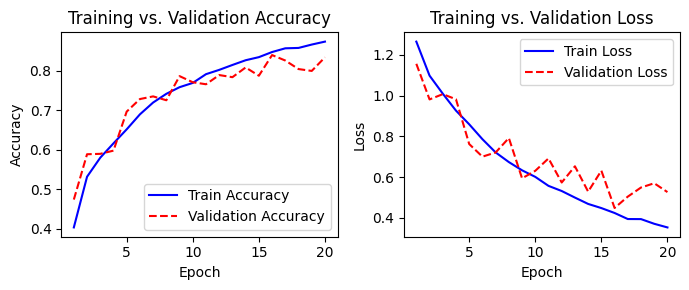

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step
                      precision    recall  f1-score   support

              fabric       0.86      0.94      0.89      1097
      non-recyclable       0.81      0.75      0.78       434
               paper       0.73      0.84      0.78       527
recyclable-inorganic       0.90      0.75      0.82       911

            accuracy                           0.84      2969
           macro avg       0.82      0.82      0.82      2969
        weighted avg       0.84      0.84      0.83      2969



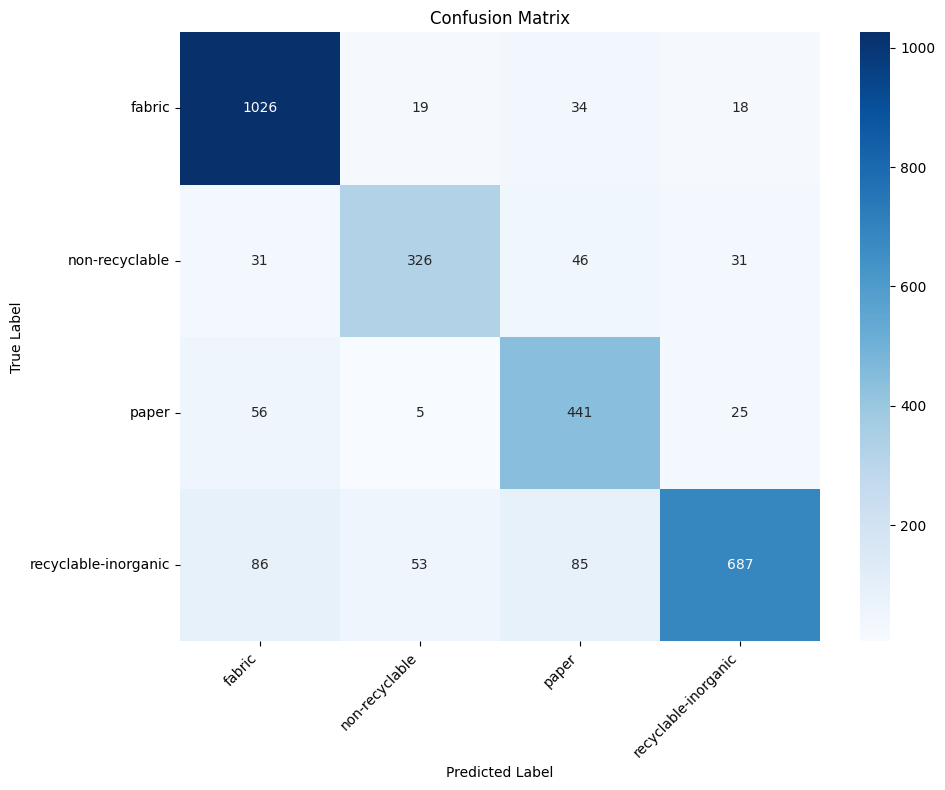

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
import tensorflow as tf
with tf.device('/GPU:0'):
    model = Sequential([
        # Block 1: 32 filters
        Conv2D(32, (3,3), padding='same', activation='relu',
               input_shape=(160,160,3)),
        MaxPooling2D(),
    
        # Block 2: 64 filters
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Block 3: 128 filters
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Block 4: 256 filters
        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Global pooling instead of flatten
        GlobalAveragePooling2D(),
    
        # Classifier head
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(4, activation='softmax')
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_flow,validation_data=val_flow,epochs=20,class_weight=class_weight)

import matplotlib.pyplot as plt

# 1) Extract metrics from history
train_acc   = history.history['accuracy']
val_acc     = history.history['val_accuracy']
train_loss  = history.history['loss']
val_loss    = history.history['val_loss']
epochs      = range(1, len(train_acc) + 1)

# 2) Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# — Accuracy subplot
axes[0].plot(epochs, train_acc, 'b-', label='Train Accuracy')
axes[0].plot(epochs, val_acc,   'r--', label='Validation Accuracy')
axes[0].set_title('Training vs. Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# — Loss subplot
axes[1].plot(epochs, train_loss, 'b-', label='Train Loss')
axes[1].plot(epochs, val_loss,   'r--', label='Validation Loss')
axes[1].set_title('Training vs. Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Get predictions on the test set
y_prob = model.predict(test_flow, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# 2) True labels
y_true = test_flow.classes

# 3) Build list of class names in index order
idx_to_label = {v:k for k,v in test_flow.class_indices.items()}
target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# 4) Print the classification report
print(classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    digits=2
))

# 5) Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=target_names,
    yticklabels=target_names,
    cmap='Blues'
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 

# Build CNN-RNN

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, Reshape, LSTM, Dropout, Dense
)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_flow_rnn = train_gen.flow_from_dataframe(
    dataframe=df_over,
    x_col='filename',
    y_col='label',
    target_size=(160, 160),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
val_flow_rnn = val_test_gen.flow_from_directory(
    "./garbage-split/validation",
    target_size=(160, 160),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)
test_flow_rnn = val_test_gen.flow_from_directory(
    "./garbage-split/test",
    target_size=(160, 160),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 20448 validated image filenames belonging to 4 classes.
Found 2962 images belonging to 4 classes.
Found 2969 images belonging to 4 classes.


I0000 00:00:1747233975.195723      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747233975.196586      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 10, 2560)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       1,376,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,765,700 (6.74 MB)

 Trainable params: 1,765,700 (6.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747233985.650371     129 cuda_dnn.cc:529] Loaded cuDNN version 90300


320/320 ━━━━━━━━━━━━━━━━━━━━ 180s 531ms/step - accuracy: 0.3894 - loss: 1.2832 - val_accuracy: 0.5159 - val_loss: 1.0962
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 171s 522ms/step - accuracy: 0.5520 - loss: 1.0538 - val_accuracy: 0.5469 - val_loss: 1.0716
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 166s 503ms/step - accuracy: 0.5949 - loss: 0.9731 - val_accuracy: 0.6648 - val_loss: 0.8153
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 171s 522ms/step - accuracy: 0.6421 - loss: 0.8703 - val_accuracy: 0.6810 - val_loss: 0.7864
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 170s 520ms/step - accuracy: 0.6773 - loss: 0.8020 - val_accuracy: 0.7238 - val_loss: 0.7006
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 169s 518ms/step - accuracy: 0.7146 - loss: 0.7339 - val_accuracy: 0.7367 - val_loss: 0.6863
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 169s 518ms/step - accuracy: 0.7321 - loss: 0.6922 - val_accuracy: 0.7346 - val_loss: 0.6976
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 167s 510ms/step - accuracy: 0.7498 - loss: 0.64

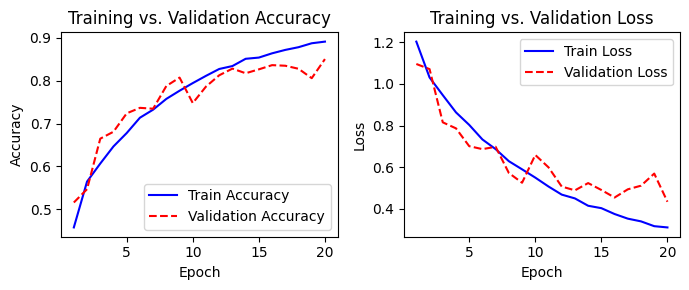

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step
                      precision    recall  f1-score   support

              fabric       0.95      0.88      0.91      1097
      non-recyclable       0.74      0.79      0.76       434
               paper       0.75      0.90      0.82       527
recyclable-inorganic       0.87      0.82      0.85       911

            accuracy                           0.85      2969
           macro avg       0.83      0.85      0.83      2969
        weighted avg       0.86      0.85      0.85      2969



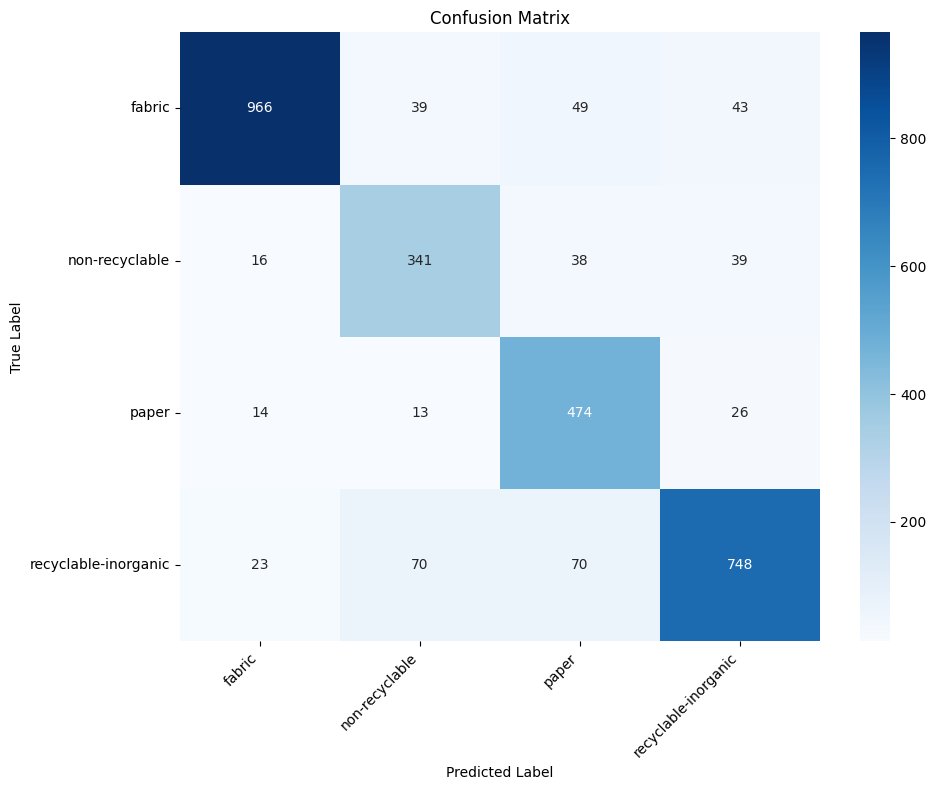

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
import tensorflow as tf
with tf.device('/GPU:0'):
    model = Sequential([
        # Block 1: 32 filters
        Conv2D(32, (3,3), padding='same', activation='relu',
               input_shape=(160,160,3)),
        MaxPooling2D(),
    
        # Block 2: 64 filters
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Block 3: 128 filters
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Block 4: 256 filters
        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),

        #Reshape for RNN, 10 timestamps
        Reshape((10, 10 * 256)), 

        LSTM(128),                            
        Dropout(0.5),
        # Classifier
        Dense(4, activation='softmax')
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(train_flow_rnn,validation_data=val_flow_rnn,epochs=20,class_weight=class_weight)

import matplotlib.pyplot as plt

# 1) Extract metrics from history
train_acc   = history.history['accuracy']
val_acc     = history.history['val_accuracy']
train_loss  = history.history['loss']
val_loss    = history.history['val_loss']
epochs      = range(1, len(train_acc) + 1)

# 2) Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# — Accuracy subplot
axes[0].plot(epochs, train_acc, 'b-', label='Train Accuracy')
axes[0].plot(epochs, val_acc,   'r--', label='Validation Accuracy')
axes[0].set_title('Training vs. Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# — Loss subplot
axes[1].plot(epochs, train_loss, 'b-', label='Train Loss')
axes[1].plot(epochs, val_loss,   'r--', label='Validation Loss')
axes[1].set_title('Training vs. Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Get predictions on the test set
y_prob = model.predict(test_flow, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# 2) True labels
y_true = test_flow.classes

# 3) Build list of class names in index order
idx_to_label = {v:k for k,v in test_flow.class_indices.items()}
target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# 4) Print the classification report
print(classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    digits=2
))

# 5) Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=target_names,
    yticklabels=target_names,
    cmap='Blues'
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Tuning CNN+RNN

In [15]:
import os
import random
import itertools
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    Reshape, LSTM, GRU,
    Dropout, Dense
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

# ─── Hyperparameter grid ─────────────────────────────────────────
param_grid = {
    'rnn_class':  [LSTM, GRU],
    'rnn_units':  [64, 128, 256],
    'dropout':    [0.4, 0.5, 0.6],
    'optimizer':  [Adam, RMSprop],
    'lr':         [1e-3],
    'batch_size': [32, 64],
}

all_combos = list(itertools.product(*param_grid.values()))
trials = random.sample(all_combos, k=8)

results = []

# ───  Data generators ───────────────────────────────────────────────
train_base_rcnn = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_base_rcnn = ImageDataGenerator(rescale=1./255)



# ───Random-search loop ───────────────────────────────────────────
for rnn_cls, rnn_units, rnn_dropout, opt_cls, lr, bs in trials:
    tf.keras.backend.clear_session()
    print(
        f"Trial → RNN: {rnn_cls.__name__}({rnn_units}), "
        f"dropout={rnn_dropout}, opt={opt_cls.__name__}(lr={lr}), "
        f"batch_size={bs}"
    )

    # — data flows with this batch size —
    train_flow = train_base_rcnn.flow_from_dataframe(
        dataframe=df_over,
        x_col='filename', y_col='label',
        target_size=(160,160),
        batch_size=bs,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    val_flow = val_base_rcnn.flow_from_directory(
        "./garbage-split/validation",
        target_size=(160,160),
        batch_size=bs,
        class_mode='categorical',
        shuffle=False
    )

    # — build & compile model —
    with tf.device('/GPU:0'):
        model = Sequential([
            Conv2D(32, (3,3), padding='same', activation='relu',
                   input_shape=(160,160,3)),
            MaxPooling2D(),

            Conv2D(64, (3,3), padding='same', activation='relu'),
            MaxPooling2D(),

            Conv2D(128, (3,3), padding='same', activation='relu'),
            MaxPooling2D(),

            Conv2D(256, (3,3), padding='same', activation='relu'),
            MaxPooling2D(),

            # feature-map is now 10×10×256
            Reshape((10, 10 * 256)),

            # RNN head
            rnn_cls(rnn_units),
            Dropout(rnn_dropout),

            # classifier
            Dense(4, activation='softmax')
        ])

        optimizer = opt_cls(learning_rate=lr)
        model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

    # — train —
    history = model.fit(train_flow,validation_data=val_flow,epochs=10,class_weight=class_weight,verbose=1)

    # — record best validation accuracy —
    best_val = max(history.history['val_accuracy'])
    results.append({
        'rnn':         rnn_cls.__name__,
        'units':       rnn_units,
        'dropout':     rnn_dropout,
        'optimizer':   opt_cls.__name__,
        'lr':          lr,
        'batch_size':  bs,
        'best_val_acc': best_val
    })

# ─── 5) Summarize ─────────────────────────────────────────────────────
df_results = pd.DataFrame(results).sort_values('best_val_acc', ascending=False)
print("\n=== Top Configurations ===")
print(df_results.head())


Trial → RNN: GRU(128), dropout=0.6, opt=RMSprop(lr=0.001), batch_size=32
Found 20448 validated image filenames belonging to 4 classes.
Found 2962 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 159s 243ms/step - accuracy: 0.3567 - loss: 1.3432 - val_accuracy: 0.5479 - val_loss: 1.0605
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 155s 239ms/step - accuracy: 0.5346 - loss: 1.1059 - val_accuracy: 0.4841 - val_loss: 1.1624
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 155s 241ms/step - accuracy: 0.5936 - loss: 0.9839 - val_accuracy: 0.6141 - val_loss: 0.9023
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 155s 240ms/step - accuracy: 0.6398 - loss: 0.8955 - val_accuracy: 0.6192 - val_loss: 0.9095
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 156s 241ms/step - accuracy: 0.6678 - loss: 0.8362 - val_accuracy: 0.7255 - val_loss: 0.7081
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 157s 243ms/step - accuracy: 0.6983 - loss: 0.7837 - val_accuracy: 0.6506 - val_loss: 0.8540
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 155s 239ms/step - accuracy: 0.7252 - loss: 0.7175 - val_accuracy: 0.7620 - val_loss: 0.6106
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 153s 236ms/step - accuracy: 0.7451 - loss: 0.68

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 155s 464ms/step - accuracy: 0.3901 - loss: 1.2824 - val_accuracy: 0.5628 - val_loss: 1.0004
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 152s 466ms/step - accuracy: 0.5597 - loss: 1.0474 - val_accuracy: 0.5361 - val_loss: 1.1040
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 156s 477ms/step - accuracy: 0.5988 - loss: 0.9614 - val_accuracy: 0.5854 - val_loss: 0.9792
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 160s 490ms/step - accuracy: 0.6338 - loss: 0.8918 - val_accuracy: 0.6523 - val_loss: 0.8235
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 149s 455ms/step - accuracy: 0.6694 - loss: 0.8157 - val_accuracy: 0.6793 - val_loss: 0.8236
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 147s 449ms/step - accuracy: 0.6997 - loss: 0.7635 - val_accuracy: 0.6688 - val_loss: 0.8181
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 150s 459ms/step - accuracy: 0.7229 - loss: 0.7221 - val_accuracy: 0.7161 - val_loss: 0.7014
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 442ms/step - accuracy: 0.7449 - loss: 0.65

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 150s 229ms/step - accuracy: 0.3694 - loss: 1.3238 - val_accuracy: 0.5321 - val_loss: 1.1189
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 148s 229ms/step - accuracy: 0.5513 - loss: 1.0776 - val_accuracy: 0.6455 - val_loss: 0.8913
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 148s 229ms/step - accuracy: 0.5963 - loss: 0.9864 - val_accuracy: 0.6050 - val_loss: 0.9515
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 228ms/step - accuracy: 0.6370 - loss: 0.8990 - val_accuracy: 0.7070 - val_loss: 0.7442
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 146s 227ms/step - accuracy: 0.6816 - loss: 0.8090 - val_accuracy: 0.7110 - val_loss: 0.7457
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 228ms/step - accuracy: 0.7083 - loss: 0.7444 - val_accuracy: 0.7093 - val_loss: 0.7417
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 227ms/step - accuracy: 0.7258 - loss: 0.7028 - val_accuracy: 0.7083 - val_loss: 0.7560
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 228ms/step - accuracy: 0.7540 - loss: 0.63

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 149s 227ms/step - accuracy: 0.3818 - loss: 1.3004 - val_accuracy: 0.5078 - val_loss: 1.1102
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 147s 227ms/step - accuracy: 0.5515 - loss: 1.0596 - val_accuracy: 0.6242 - val_loss: 0.9201
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 148s 229ms/step - accuracy: 0.5998 - loss: 0.9754 - val_accuracy: 0.5709 - val_loss: 1.0317
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 155s 240ms/step - accuracy: 0.6262 - loss: 0.9089 - val_accuracy: 0.5773 - val_loss: 0.9988
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 154s 238ms/step - accuracy: 0.6522 - loss: 0.8600 - val_accuracy: 0.6907 - val_loss: 0.7776
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 151s 233ms/step - accuracy: 0.6863 - loss: 0.7992 - val_accuracy: 0.6384 - val_loss: 0.9036
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 151s 234ms/step - accuracy: 0.7109 - loss: 0.7621 - val_accuracy: 0.6830 - val_loss: 0.7634
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 150s 232ms/step - accuracy: 0.7164 - loss: 0.73

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 153s 234ms/step - accuracy: 0.3672 - loss: 1.3121 - val_accuracy: 0.5287 - val_loss: 1.0583
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 150s 233ms/step - accuracy: 0.5483 - loss: 1.0714 - val_accuracy: 0.5780 - val_loss: 0.9934
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 150s 232ms/step - accuracy: 0.5951 - loss: 0.9929 - val_accuracy: 0.6185 - val_loss: 0.9019
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 151s 234ms/step - accuracy: 0.6314 - loss: 0.9146 - val_accuracy: 0.6492 - val_loss: 0.8662
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 150s 233ms/step - accuracy: 0.6592 - loss: 0.8614 - val_accuracy: 0.6772 - val_loss: 0.7823
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 150s 232ms/step - accuracy: 0.6860 - loss: 0.8137 - val_accuracy: 0.7093 - val_loss: 0.7313
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 151s 234ms/step - accuracy: 0.7106 - loss: 0.7568 - val_accuracy: 0.6567 - val_loss: 0.8940
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 153s 238ms/step - accuracy: 0.7239 - loss: 0.72

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 155s 464ms/step - accuracy: 0.3342 - loss: 1.3494 - val_accuracy: 0.5405 - val_loss: 1.0885
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 152s 465ms/step - accuracy: 0.5178 - loss: 1.1336 - val_accuracy: 0.5027 - val_loss: 1.1670
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 152s 466ms/step - accuracy: 0.5727 - loss: 1.0458 - val_accuracy: 0.6036 - val_loss: 0.9974
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 151s 461ms/step - accuracy: 0.6193 - loss: 0.9539 - val_accuracy: 0.6377 - val_loss: 0.8946
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 150s 459ms/step - accuracy: 0.6402 - loss: 0.8953 - val_accuracy: 0.6590 - val_loss: 0.8202
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 148s 453ms/step - accuracy: 0.6682 - loss: 0.8489 - val_accuracy: 0.6617 - val_loss: 0.8496
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 148s 453ms/step - accuracy: 0.6923 - loss: 0.7979 - val_accuracy: 0.7124 - val_loss: 0.7366
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 147s 449ms/step - accuracy: 0.7106 - loss: 0.74

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 155s 467ms/step - accuracy: 0.3270 - loss: 1.4059 - val_accuracy: 0.5621 - val_loss: 1.0893
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 148s 454ms/step - accuracy: 0.4992 - loss: 1.1678 - val_accuracy: 0.5969 - val_loss: 1.0029
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 150s 460ms/step - accuracy: 0.5712 - loss: 1.0388 - val_accuracy: 0.5979 - val_loss: 0.9553
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 148s 452ms/step - accuracy: 0.6011 - loss: 0.9586 - val_accuracy: 0.6121 - val_loss: 0.9786
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 150s 458ms/step - accuracy: 0.6420 - loss: 0.8788 - val_accuracy: 0.7248 - val_loss: 0.7175
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 147s 451ms/step - accuracy: 0.6692 - loss: 0.8257 - val_accuracy: 0.6867 - val_loss: 0.7992
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 149s 456ms/step - accuracy: 0.6935 - loss: 0.7706 - val_accuracy: 0.7309 - val_loss: 0.6824
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 151s 464ms/step - accuracy: 0.7183 - loss: 0.71

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 150s 449ms/step - accuracy: 0.3846 - loss: 1.2828 - val_accuracy: 0.5820 - val_loss: 0.9941
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 146s 449ms/step - accuracy: 0.5759 - loss: 1.0186 - val_accuracy: 0.5928 - val_loss: 0.9356
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 445ms/step - accuracy: 0.6297 - loss: 0.9149 - val_accuracy: 0.6212 - val_loss: 0.9152
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 146s 447ms/step - accuracy: 0.6645 - loss: 0.8482 - val_accuracy: 0.6408 - val_loss: 0.8556
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 146s 446ms/step - accuracy: 0.6908 - loss: 0.7816 - val_accuracy: 0.7046 - val_loss: 0.7435
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 440ms/step - accuracy: 0.7279 - loss: 0.7048 - val_accuracy: 0.7279 - val_loss: 0.6781
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 143s 437ms/step - accuracy: 0.7516 - loss: 0.6475 - val_accuracy: 0.7151 - val_loss: 0.7365
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 442ms/step - accuracy: 0.7734 - loss: 0.59

## best Parameter After Tuning

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, Reshape, LSTM, GRU, Dropout, Dense
)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_gen = ImageDataGenerator(rescale=1./255)

train_flow_rnn = train_gen.flow_from_dataframe(
    dataframe=df_over,
    x_col='filename',
    y_col='label',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
val_flow_rnn = val_test_gen.flow_from_directory(
    "./garbage-split/validation",
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
test_flow_rnn = val_test_gen.flow_from_directory(
    "./garbage-split/test",
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 20448 validated image filenames belonging to 4 classes.
Found 2962 images belonging to 4 classes.
Found 2969 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 10, 2560)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 256)                 │       2,164,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,553,668 (9.74 MB)

 Trainable params: 2,553,668 (9.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 149s 227ms/step - accuracy: 0.3473 - loss: 1.3321 - val_accuracy: 0.5560 - val_loss: 1.0608
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 225ms/step - accuracy: 0.5394 - loss: 1.1027 - val_accuracy: 0.6307 - val_loss: 0.9267
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 224ms/step - accuracy: 0.5982 - loss: 0.9793 - val_accuracy: 0.6627 - val_loss: 0.8103
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.6470 - loss: 0.8867 - val_accuracy: 0.6111 - val_loss: 1.0074
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 222ms/step - accuracy: 0.6769 - loss: 0.8254 - val_accuracy: 0.7292 - val_loss: 0.7187
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.7042 - loss: 0.7512 - val_accuracy: 0.7282 - val_loss: 0.7361
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 144s 224ms/step - accuracy: 0.7385 - loss: 0.6886 - val_accuracy: 0.7694 - val_loss: 0.6141
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 145s 224ms/step - accuracy: 0.7451 - loss: 0.66

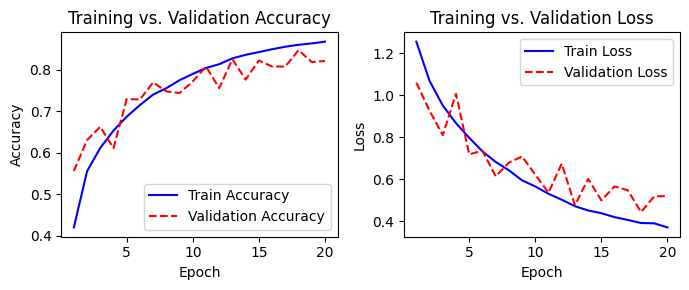

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
                      precision    recall  f1-score   support

              fabric       0.90      0.84      0.87      1097
      non-recyclable       0.83      0.69      0.75       434
               paper       0.60      0.94      0.73       527
recyclable-inorganic       0.93      0.76      0.84       911

            accuracy                           0.81      2969
           macro avg       0.81      0.81      0.80      2969
        weighted avg       0.84      0.81      0.82      2969



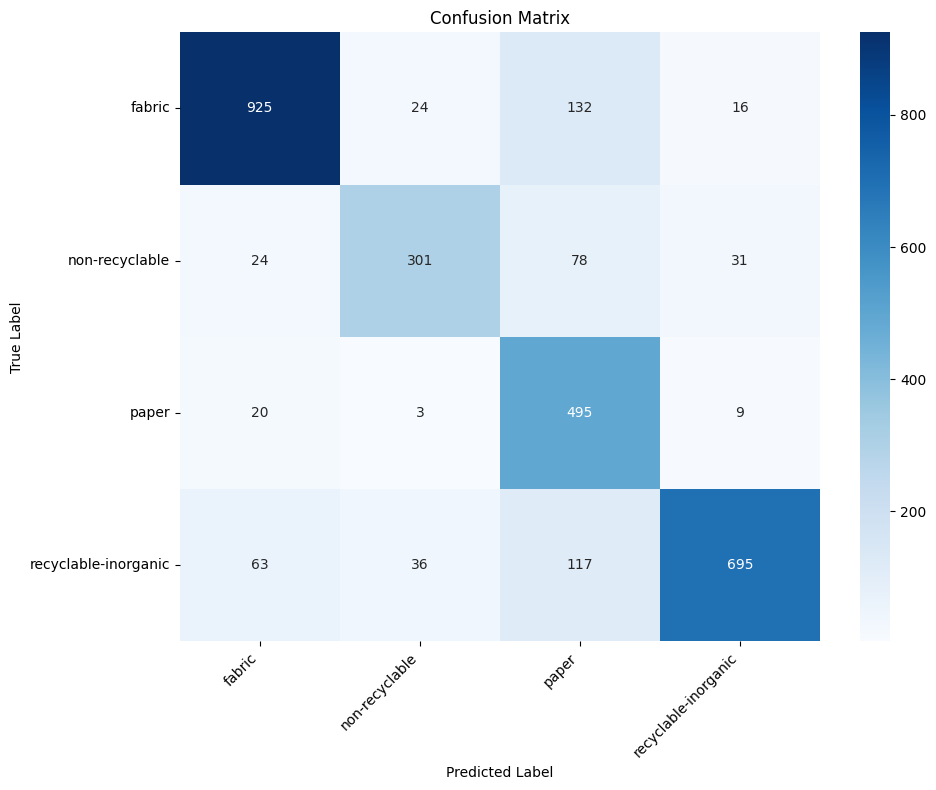

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
with tf.device('/GPU:0'):
    model = Sequential([
        # Block 1: 32 filters
        Conv2D(32, (3,3), padding='same', activation='relu',
               input_shape=(160,160,3)),
        MaxPooling2D(),
    
        # Block 2: 64 filters
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Block 3: 128 filters
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),
    
        # Block 4: 256 filters
        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D(),

        #Reshape for RNN, 10 timestamps
        Reshape((10, 10 * 256)), 

        GRU(256),                            
        Dropout(0.5),
        # Classifier
        Dense(4, activation='softmax')
    ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_flow_rnn,validation_data=val_flow_rnn,epochs=20,class_weight=class_weight)

import matplotlib.pyplot as plt

# 1) Extract metrics from history
train_acc   = history.history['accuracy']
val_acc     = history.history['val_accuracy']
train_loss  = history.history['loss']
val_loss    = history.history['val_loss']
epochs      = range(1, len(train_acc) + 1)

# 2) Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# — Accuracy subplot
axes[0].plot(epochs, train_acc, 'b-', label='Train Accuracy')
axes[0].plot(epochs, val_acc,   'r--', label='Validation Accuracy')
axes[0].set_title('Training vs. Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# — Loss subplot
axes[1].plot(epochs, train_loss, 'b-', label='Train Loss')
axes[1].plot(epochs, val_loss,   'r--', label='Validation Loss')
axes[1].set_title('Training vs. Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Get predictions on the test set
y_prob = model.predict(test_flow, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# 2) True labels
y_true = test_flow.classes

# 3) Build list of class names in index order
idx_to_label = {v:k for k,v in test_flow.class_indices.items()}
target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# 4) Print the classification report
print(classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    digits=2
))

# 5) Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=target_names,
    yticklabels=target_names,
    cmap='Blues'
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()